<a href="https://colab.research.google.com/github/HMMJ-1991/bike-sharing/blob/master/prophet_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <font color="red">Import packages </font>

In [1]:


#Include holiday data for demand prediction using prophet
#refering https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html
#!pip install fbprophet
#https://facebook.github.io/prophet/docs/installation.html
from fbprophet import Prophet
import holidays
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import glob



Importing plotly failed. Interactive plots will not work.


In [2]:
member_daily=pd.read_csv('../dc/member_daily.csv') #done for member daily
casual_daily=pd.read_csv('../dc/casual_daily.csv') #done for member daily
print('Registed rides: ' + str(member_daily['number of users'].sum()))
print('Casual rides: ' + str(casual_daily['number of users'].sum()))
# print(member_daily.head())

data = pd.concat([member_daily, casual_daily], ignore_index=True)
# print(data.shape)

data= data.groupby(['date']).sum().reset_index()
print('Total rides: ' + str(data['number of users'].sum()))
data.to_csv(r'../dc/daily_count.csv', index = False)

Registed rides: 119530
Casual rides: 9984
Total rides: 129514


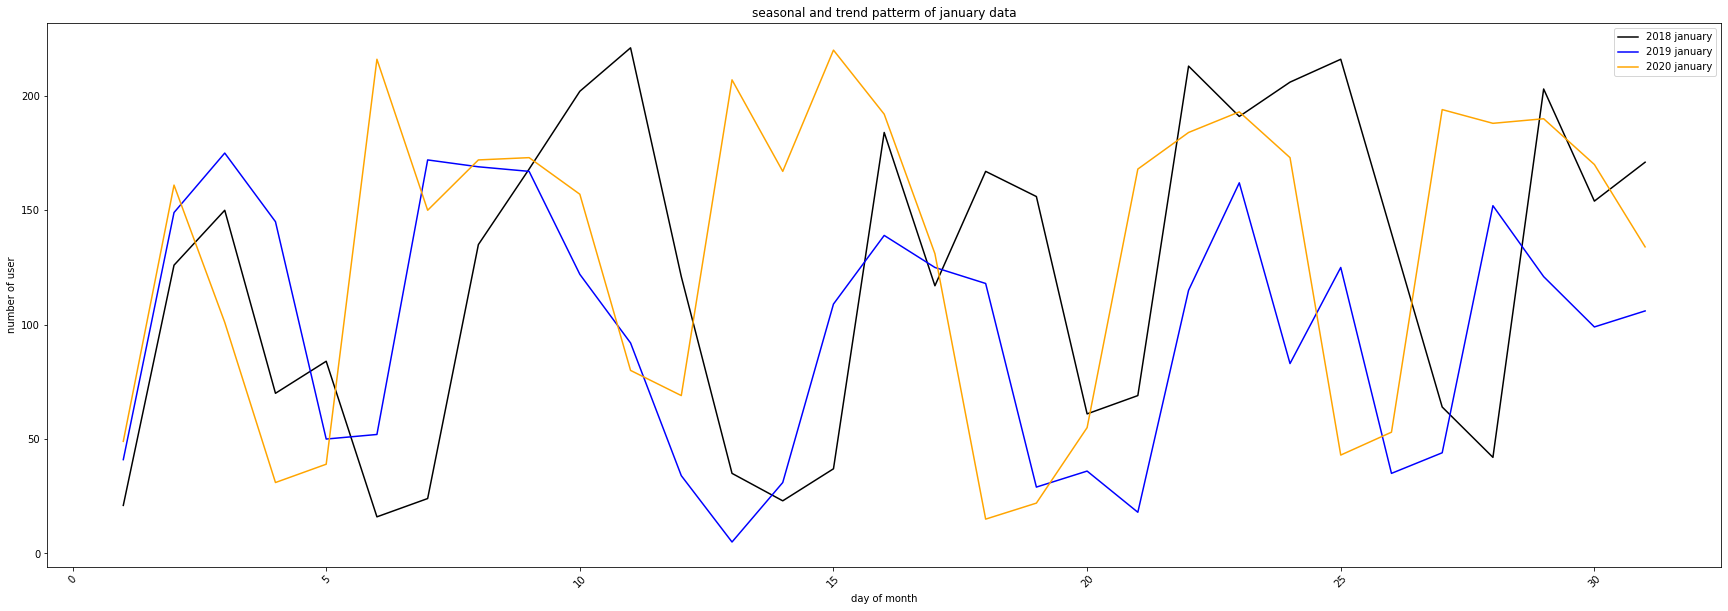

In [3]:
data['date']=pd.to_datetime(data['date'])
data['day']=data['date'].dt.day

data_jan=data[data.date.dt.month==1]
data_2018_jan=data_jan[data_jan.date.dt.year==2018]
data_2019_jan=data_jan[data_jan.date.dt.year==2019]
data_2020_jan=data_jan[data_jan.date.dt.year==2020]

fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(rotation=45)
plt.title('seasonal and trend patterm of january data')
plt.plot(data_2018_jan['day'],data_2018_jan['number of users'],label='2018 january',color='black')
plt.plot(data_2019_jan['day'],data_2019_jan['number of users'],label='2019 january',color='blue')
plt.plot(data_2020_jan['day'],data_2020_jan['number of users'],label='2020 january',color='orange')
plt.legend()
plt.xlabel('day of month')
plt.ylabel('number of user')
plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


expected test size is 60, actual size: 60


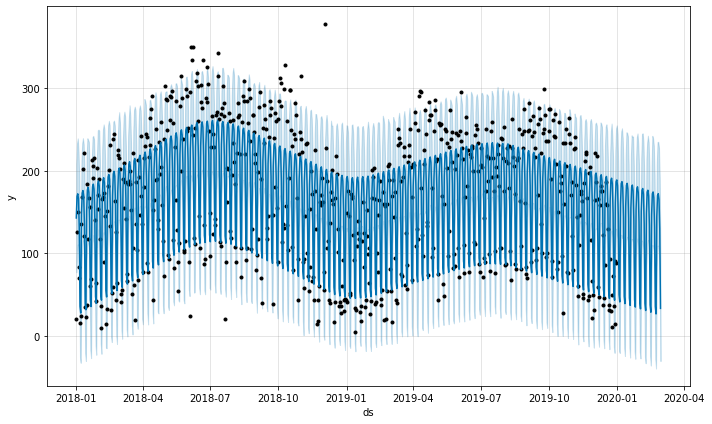

In [7]:
data1=data[['date','number of users']]
data1.columns=['ds','y']

data_train=data1.iloc[0:-60,:]
data_test=data1.iloc[-60:,:]

print('expected test size is 60, actual size: '+str(len(data_test))) # two months

model = Prophet()
model.fit(data_train)
future_data = model.make_future_dataframe(periods=60, freq = 'd')
forecast_data = model.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

model.plot(forecast_data)
plt.show()

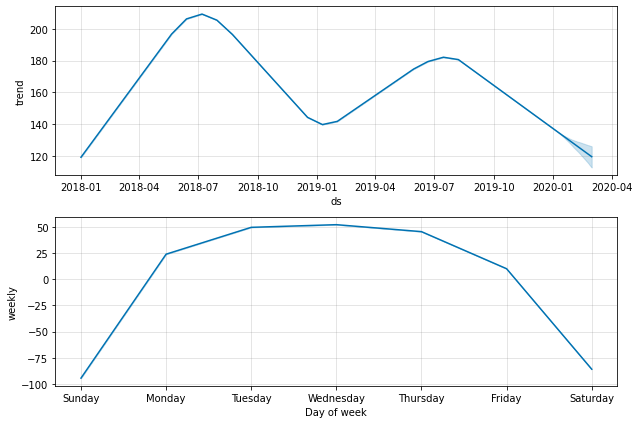

In [8]:
model.plot_components(forecast_data)
plt.show()

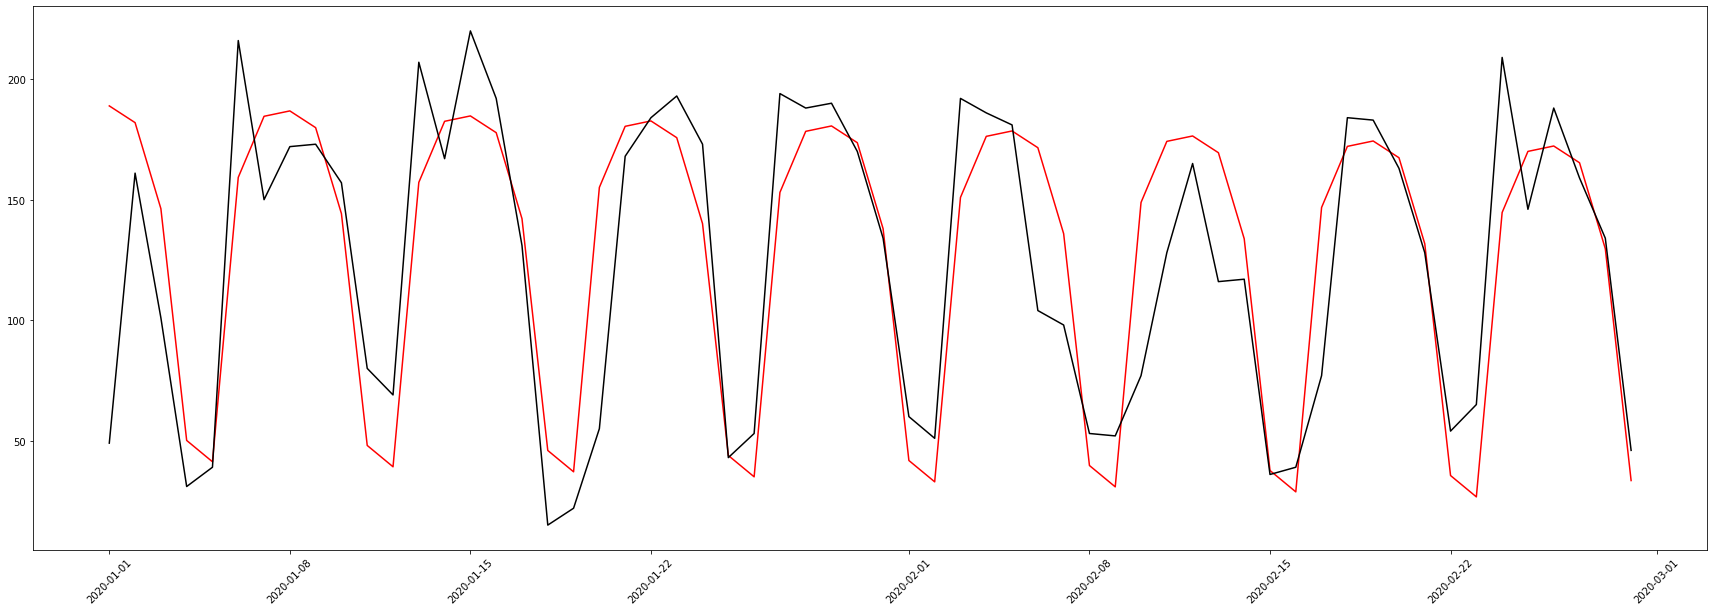

In [10]:
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(rotation=45)
plt.plot(forecast_data['ds'].iloc[-60:],forecast_data["yhat"].iloc[-60:],color='red')
plt.plot(data_test['ds'],data_test["y"],color='black')


In [12]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='60 days', period='60 days', horizon = '60 days')
df_cv.head()

INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-03-11 00:00:00 and 2019-11-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-03-12,167.623662,119.061752,218.707549,184,2018-03-11
1,2018-03-13,212.724953,165.387079,262.831790,188,2018-03-11
2,2018-03-14,203.325996,154.426990,252.235423,200,2018-03-11
3,2018-03-15,210.127120,159.764295,260.845842,184,2018-03-11
4,2018-03-16,149.727928,103.411199,197.993501,153,2018-03-11


In [13]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
print(df_p.head())
df_p.to_csv(r'../data/performance_metrics.csv', index = False)


  horizon          mse       rmse        mae      mape     mdape  coverage
0  6 days  2108.336554  45.916626  34.410052  0.302592  0.145552  0.878788
1  7 days  2664.258882  51.616459  38.183986  0.332817  0.182837  0.818182
2  8 days  3126.790716  55.917714  41.596075  0.366336  0.218365  0.772727
3  9 days  4120.616670  64.192030  47.201251  0.486713  0.261212  0.712121
4 10 days  5027.006555  70.901386  52.446808  0.657860  0.317362  0.651515


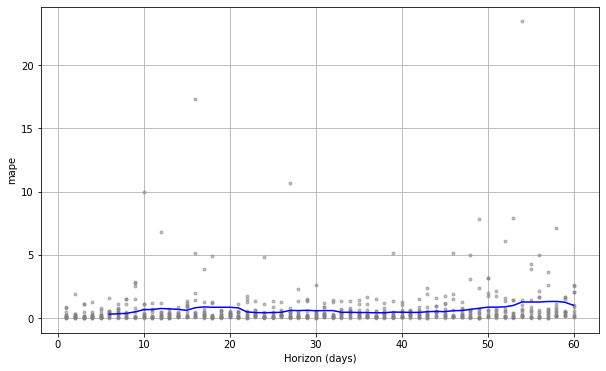

In [14]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

### <font color="red">Include Holidays in the analytics </font>

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


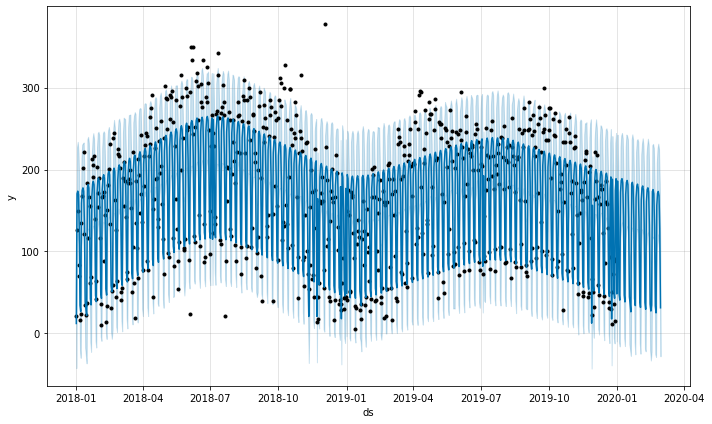

In [15]:
#Include Holidays in the analytics

data['date']=pd.to_datetime(data['date'])
data['day']=data['date'].dt.day

data1=data[['date','number of users']]
data1.columns=['ds','y']

data_train=data1.iloc[0:-60,:]
data_test=data1.iloc[-60:,:]

model = Prophet()
#using inbuilt holidays
model.add_country_holidays(country_name='US')
model.fit(data_train)


future_data = model.make_future_dataframe(periods=60, freq = 'd')
forecast_data = model.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

model.plot(forecast_data)
plt.show()


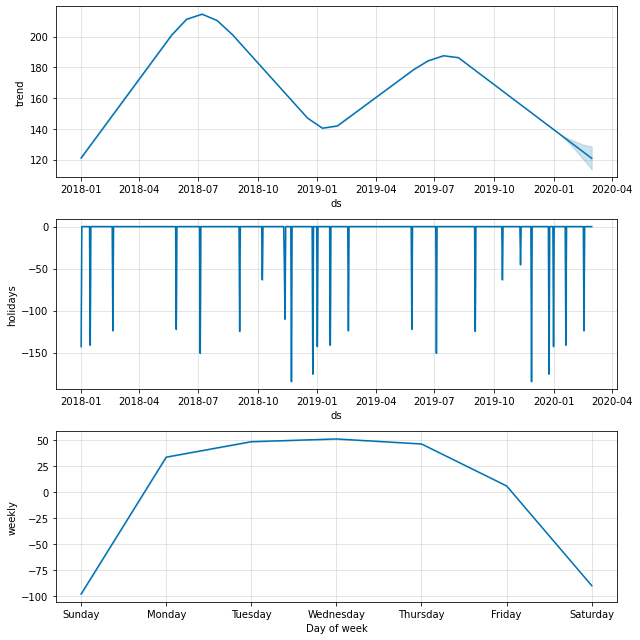

<Figure size 432x288 with 0 Axes>

In [23]:
model.plot_components(forecast_data)
plt.show()
plt.savefig('../figures/plots_with_holiday.png')


INFO:fbprophet:Making 11 forecasts with cutoffs between 2018-03-11 00:00:00 and 2019-11-01 00:00:00


  horizon          mse       rmse        mae      mape     mdape  coverage
0  6 days  1972.257205  44.410103  33.344315  0.292473  0.133883  0.848485
1  7 days  2531.698993  50.315991  37.346253  0.323722  0.182199  0.772727
2  8 days  2987.716591  54.660009  40.649630  0.342298  0.210840  0.712121
3  9 days  3988.731232  63.156403  46.480329  0.471058  0.262367  0.651515
4 10 days  4890.510598  69.932186  51.789420  0.639483  0.313063  0.621212


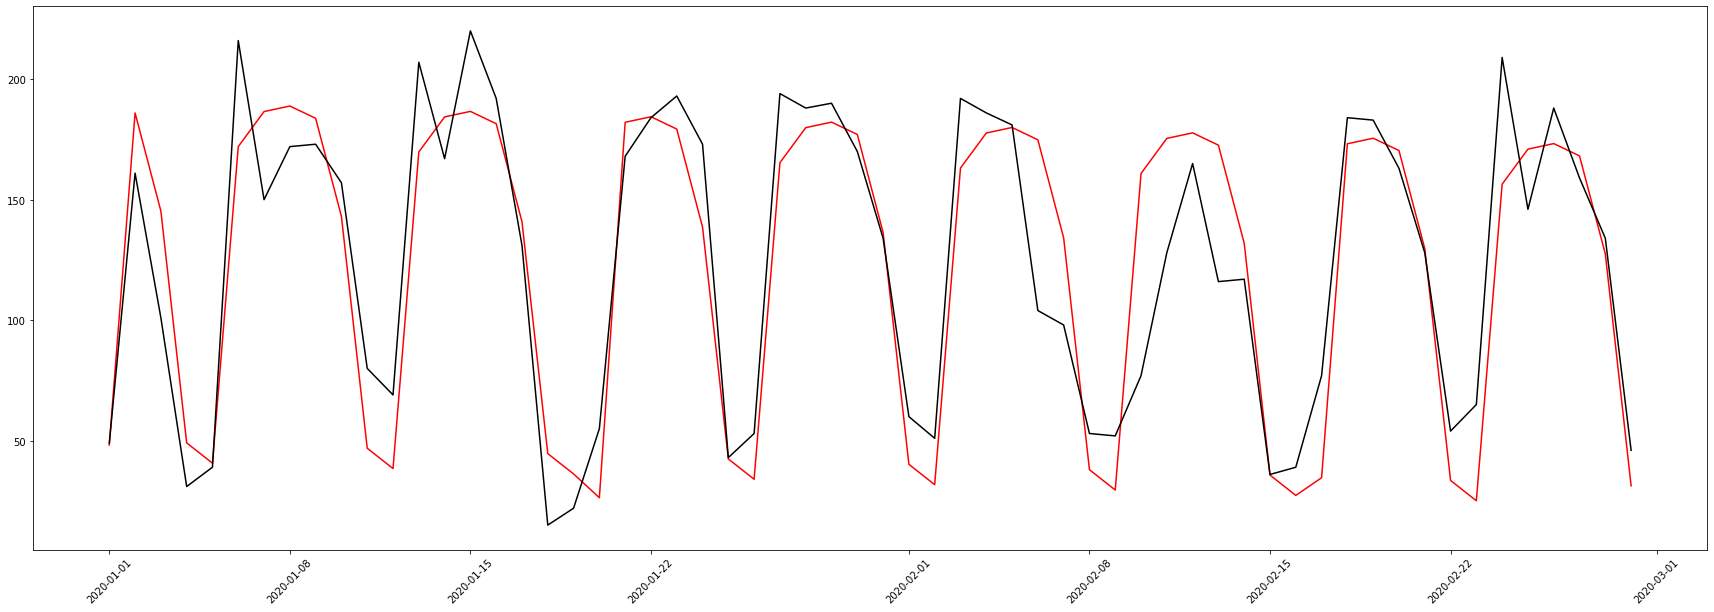

In [17]:
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(rotation=45)
plt.plot(forecast_data['ds'].iloc[-60:],forecast_data["yhat"].iloc[-60:],color='red')
plt.plot(data_test['ds'],data_test["y"],color='black')


from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='60 days', period='60 days', horizon = '60 days')
df_cv.head()

from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
print(df_p.head())

df_p.to_csv(r'../data/performance_metrics_with_holidays.csv', index = False)



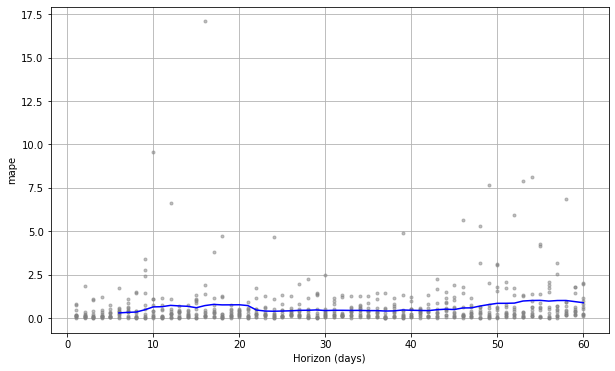

In [18]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

Metric head
    horizon          mse       rmse        mae      mape     mdape  coverage
0   6 days   2108.336554  45.916626  34.410052  0.302592  0.145552  0.878788
1   7 days   2664.258882  51.616459  38.183986  0.332817  0.182837  0.818182
2   8 days   3126.790716  55.917714  41.596075  0.366336  0.218365  0.772727
3   9 days   4120.616670  64.192030  47.201251  0.486713  0.261212  0.712121
4  10 days   5027.006555  70.901386  52.446808  0.657860  0.317362  0.651515

Metric with holidays
    horizon          mse       rmse        mae      mape     mdape  coverage
0   6 days   1972.257205  44.410103  33.344315  0.292473  0.133883  0.848485
1   7 days   2531.698993  50.315991  37.346253  0.323722  0.182199  0.772727
2   8 days   2987.716591  54.660009  40.649630  0.342298  0.210840  0.712121
3   9 days   3988.731232  63.156403  46.480329  0.471058  0.262367  0.651515
4  10 days   4890.510598  69.932186  51.789420  0.639483  0.313063  0.621212


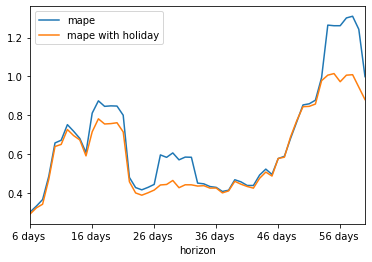

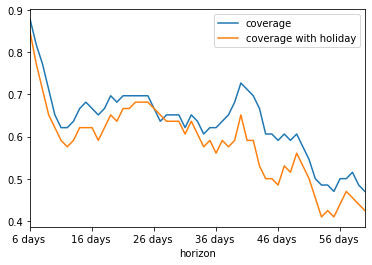

In [21]:
#mape vs horizon (6-10)
metric=pd.read_csv('../data/performance_metrics.csv') #done for member daily
metric_with_holidays=pd.read_csv('../data/performance_metrics_with_holidays.csv') #done for member daily
metric['horizon'] = metric['horizon'].map(lambda x: x[:-18])
metric_with_holidays['horizon'] = metric_with_holidays['horizon'].map(lambda x: x[:-18])
print('Metric head')
print(metric.head())
print('\nMetric with holidays')
print(metric_with_holidays.head())

mape=metric[['horizon','mape']]
mape['mape with holiday'] = metric_with_holidays['mape']
mape.set_index('horizon', inplace=True)
#print(mape)

#print(mape['horizon'].iloc[0] in mape.index)

lines =mape.plot.line()
plt.savefig('../figures/compare_mape_holiday_effect.png')


coverage=metric[['horizon','coverage']]
coverage['coverage with holiday'] = metric_with_holidays['coverage']
coverage.set_index('horizon', inplace=True)
lines =coverage.plot.line()

plt.savefig('../figures/compare_coverage_holiday_effect.png')
